In [668]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from sklearn.model_selection import train_test_split

plt.style.use('seaborn-v0_8-ticks')
%config InlineBackend.figure_formats =['svg']

In [669]:
import copy
class EarlyStopping:
    """
    Parameters
    ----------
    patience : float
        How long should we wait until there are no improvements
    minDelta : float
        Small values, The minimum change that should be considered as an improvement.
    restoreBestWeights : bool
        Restore the best weight settings, when there is no overfitting!
    """

    def __init__(self,patience=5, minDelta=0, restoreBestWeights=True):
        # EarlyParams
        self.patience = patience
        self.minDelta = minDelta
        self.restoreBestWeights = restoreBestWeights
        self.best_epoch = 0
        # Restore Options
        self.bestModel  = None
        self.bestLoss   = None
        self.counter    = 0
        self.status     = 'Learning'

    def __call__(self, model, val_loss, epoch):

        if self.bestLoss is None: # First Visit
            self.bestModel = copy.deepcopy(model.state_dict())
            self.bestLoss = val_loss
            self.best_epoch = epoch

        elif self.bestLoss - val_loss >= self.minDelta: # check if there is any improvement
            self.bestModel   = copy.deepcopy(model.state_dict())
            self.bestLoss   = val_loss
            self.best_epoch = epoch
            self.counter    = 0 # reset counting
            self.status     = f'Learning'

        else: # Means there are no improvements
            self.counter   += 1
            self.status     = f'Waiting.'
            if self.counter >= self.patience: # Have we waited enough ?
                self.status     = f'*Finished due to no improvements on validation for {self.counter} epochs.'
                if self.restoreBestWeights: # Restore Best weights ?
                    model.load_state_dict(self.bestModel)
                return True
        return False

# Data

In [670]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0,std=1/255),
])

In [671]:
train_df = datasets.MNIST(root='./data', train=False,  transform=transform, download=False)

In [672]:
num_samples = 10000
random_samples = np.random.choice(len(train_df.data),size=(num_samples,), replace=False) # Replace -> False: means no duplicates

In [673]:
train_X = train_df.data[random_samples]
train_y = train_df.targets[random_samples]

# Exploring Data
Imbalance Data

In [674]:
uniques,counts = train_y.unique(return_counts=True)
counts

tensor([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009])

# Normalizing Dataset

In [675]:
train_X = train_X / torch.max(train_X)

# Datasets

In [676]:
X_train, X_test, y_train, y_test = train_test_split(train_X,train_y, train_size=.9)

## Fixing imbalance data

In [677]:
from torch.utils.data import WeightedRandomSampler

# Get classes count
class_counts  = torch.bincount(y_train).float()
class_weights = 1. / class_counts
weights = class_weights[y_train]

# Sampler
sampler = WeightedRandomSampler(weights=weights,num_samples=len(weights),replacement=True)

# DataSet
train_dataset = TensorDataset(X_train,y_train)
test_dataset = TensorDataset(X_test,y_test)

# Train and Test batches
train_loader = DataLoader(train_dataset, batch_size=64, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [678]:
print('========= DataLoader =========')
print(f'Training DataLoader = Elements per batch {train_loader.batch_size}, Batches = {len(train_loader)}')
print(f'Testing DataLoader = Elements per batch {test_loader.batch_size}, Batches = {len(test_loader)}')

========= DataLoader =========
Training DataLoader = Elements per batch 64, Batches = 140
Testing DataLoader = Elements per batch 1000, Batches = 1


# Fixing Balancing Batches

In [679]:
from imblearn.over_sampling import RandomOverSampler

balanced_batches = []
sampler = RandomOverSampler()

for idx,(data,label) in enumerate(train_loader):

    # Convert images from shape [64,1,28,28] to [64,784]. and flatten targets
    feature = data.view(data.size(0), -1)
    target  = label.flatten()

    feature_oversample, target_oversample = sampler.fit_resample(feature, target)

    print(np.bincount(target_oversample))
    balanced_batches.append(( torch.tensor(feature_oversample).float(), torch.tensor(target_oversample) ))

[9 9 9 9 9 9 9 9 9 9]
[9 9 9 9 9 9 9 9 9 9]
[9 9 9 9 9 9 9 9 9 9]
[10 10 10 10 10 10 10 10 10 10]
[11 11 11 11 11 11 11 11 11 11]
[12 12 12 12 12 12 12 12 12 12]
[9 9 9 9 9 9 9 9 9 9]
[11 11 11 11 11 11 11 11 11 11]
[10 10 10 10 10 10 10 10 10 10]
[11 11 11 11 11 11 11 11 11 11]
[11 11 11 11 11 11 11 11 11 11]
[8 8 8 8 8 8 8 8 8 8]
[11 11 11 11 11 11 11 11 11 11]
[14 14 14 14 14 14 14 14 14 14]
[9 9 9 9 9 9 9 9 9 9]
[8 8 8 8 8 8 8 8 8 8]
[10 10 10 10 10 10 10 10 10 10]
[12 12 12 12 12 12 12 12 12 12]
[12 12 12 12 12 12 12 12 12 12]
[9 9 9 9 9 9 9 9 9 9]
[14 14 14 14 14 14 14 14 14 14]
[10 10 10 10 10 10 10 10 10 10]
[9 9 9 9 9 9 9 9 9 9]
[12 12 12 12 12 12 12 12 12 12]
[10 10 10 10 10 10 10 10 10 10]
[9 9 9 9 9 9 9 9 9 9]
[12 12 12 12 12 12 12 12 12 12]
[11 11 11 11 11 11 11 11 11 11]
[9 9 9 9 9 9 9 9 9 9]
[10 10 10 10 10 10 10 10 10 10]
[9 9 9 9 9 9 9 9 9 9]
[10 10 10 10 10 10 10 10 10 10]
[12 12 12 12 12 12 12 12 12 12]
[10 10 10 10 10 10 10 10 10 10]
[12 12 12 12 12 12 12 12 12 12]


# Model

In [680]:
input_sz  = X_train[0].flatten().shape[0]
output_sz = 10

In [681]:
model = nn.Sequential(
    # Input
    nn.Linear(in_features=input_sz, out_features=128), # Input Gray scaled image
    nn.Tanh(),

    # Hidden Layers
    nn.Linear(in_features=128, out_features=128),
    nn.Tanh(),
    nn.Linear(in_features=128, out_features=128),
    nn.Tanh(),
    nn.Linear(in_features=128, out_features=128),
    nn.Tanh(),

    # Output
    nn.Linear(in_features=128, out_features=output_sz),
    nn.LogSoftmax(dim=1) # IMPORTANT: We must use NLLoss with Log softmax
)

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= .005, )
lr_sched  = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.9 ,step_size=5)

es = EarlyStopping(patience=25)

## Training

In [682]:
train_loss_hist = []
valid_loss_hist  = []
train_accuracy_hist  = []
valid_accuracy_hist  = []

In [683]:
for epoch_i in range(500):
    batch_acc  = []
    batch_loss = []
    model.train()

    # Training batches
    for idx, (data,label) in enumerate(balanced_batches):
        # Flatten data
        data_flatten = data

        # Forward
        yHat = model(data_flatten)

        # Batch loss
        loss = criterion(yHat,label)
        batch_loss.append(loss.item())

        # Accuracy
        TP = (torch.argmax(yHat, axis=1) == label).float()
        batch_acc.append( torch.mean( TP ).item() * 100 )

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # End of batches

    # Learning Rate scheduler
    lr_sched.step()

    # Training Loss and accuracy
    train_loss_hist.append( np.mean(batch_loss) )
    train_accuracy_hist.append( np.mean(batch_acc) )

    # Testing Accuracy
    model.eval()
    _data, _label = next(iter(test_loader))
    data_flatten = _data.view(len(_data) ,-1)
    _yHat = model(data_flatten)
    val_loss = criterion(_yHat,_label)

    # Validation Loss and accuracy
    TP = (torch.argmax(_yHat,axis=1) == _label).float()
    valid_accuracy_hist.append( torch.mean(TP)*100 )
    valid_loss_hist.append(val_loss.item())

    if es(model,val_loss,epoch_i):
        break

    # Report
    print(f'Epoch {epoch_i+1}-{es.status}:\t Training Loss {train_loss_hist[-1]} \t Training Accuracy {train_accuracy_hist[-1]}, Training Loss {valid_loss_hist[-1]} \t Training Accuracy {valid_accuracy_hist[-1]}')

Epoch 1-Learning:	 Training Loss 0.5739457123513733 	 Training Accuracy 83.00516840070486, Training Loss 0.38398414850234985 	 Training Accuracy 88.20000457763672
Epoch 2-Learning:	 Training Loss 0.3300139809825591 	 Training Accuracy 90.56744830948966, Training Loss 0.3017565608024597 	 Training Accuracy 92.5999984741211
Epoch 3-Learning:	 Training Loss 0.2335611265418785 	 Training Accuracy 93.33355230944497, Training Loss 0.2938544452190399 	 Training Accuracy 92.0999984741211
Epoch 4-Waiting.:	 Training Loss 0.1930401103038873 	 Training Accuracy 94.43956877504077, Training Loss 0.303445965051651 	 Training Accuracy 91.79999542236328
Epoch 5-Waiting.:	 Training Loss 0.16969779656667794 	 Training Accuracy 94.97342616319656, Training Loss 0.2982422709465027 	 Training Accuracy 91.5
Epoch 6-Learning:	 Training Loss 0.11502317455597222 	 Training Accuracy 96.59954530852181, Training Loss 0.25746142864227295 	 Training Accuracy 93.69999694824219
Epoch 7-Learning:	 Training Loss 0.09193

# results visualization

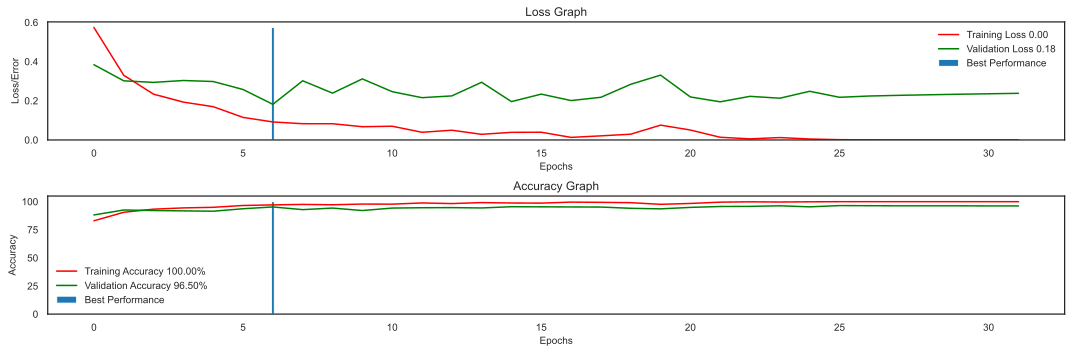

In [698]:
plt.figure(figsize=(15,5))

# Loss Graph
plt.subplot(2,1,1)
plt.plot(train_loss_hist,'-r')
plt.plot(valid_loss_hist,'-g')
plt.bar(es.best_epoch,np.max(train_loss_hist),width=0.1)
plt.xlabel('Epochs')
plt.ylabel('Loss/Error')
plt.title('Loss Graph')
plt.legend([f'Training Loss {np.min(train_loss_hist):.2f}',f'Validation Loss {np.min(valid_loss_hist):.2f}', 'Best Performance'])

# Accuracy Graph
plt.subplot(2,1,2)
plt.plot(train_accuracy_hist,'-r')
plt.plot(valid_accuracy_hist,'-g')
plt.bar(es.best_epoch,100,width=0.1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend([f'Training Accuracy {np.max(train_accuracy_hist):.2f}%',f'Validation Accuracy {np.max(valid_accuracy_hist):.2f}%','Best Performance'])

plt.tight_layout()
plt.show()

## Visualize a random prediction

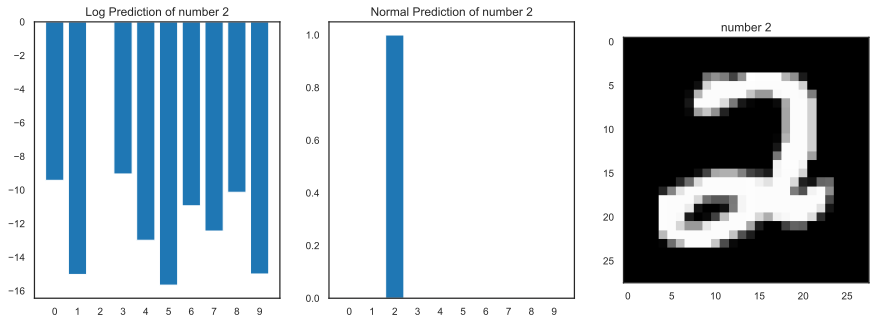

In [685]:
ch = np.random.choice(len(X_test))

prediction = model(X_test[ch].view(1,-1))

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title(f'Log Prediction of number {y_test[ch]}')
plt.bar(range(10), prediction.detach().flatten())
plt.xticks(range(10))

plt.subplot(1,3,2)
plt.title(f'Normal Prediction of number {y_test[ch]}')
plt.bar(range(10), torch.exp(prediction.detach().flatten()))
plt.xticks(range(10))

plt.subplot(1,3,3)
plt.title(f'number {y_test[ch]}')
plt.imshow(X_test[ch],cmap='gray')

plt.show()

## Visualize a mistake

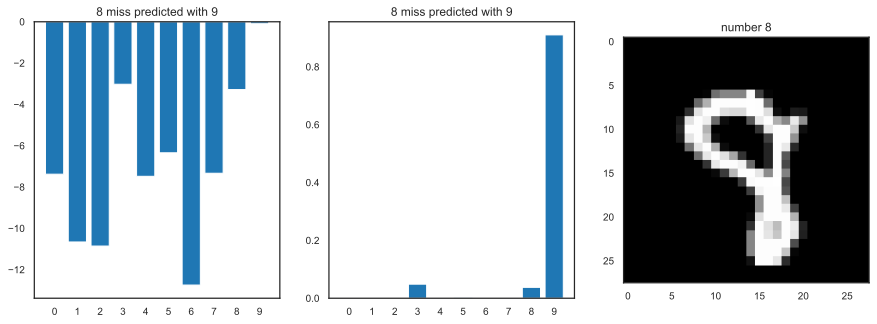

In [686]:
prediction = model(X_test.view(len(X_test),-1))
prediction_labels = np.argmax(prediction.detach(),axis=1)
miss_predictions = np.argwhere( prediction_labels != y_test)[0]

ch = np.random.choice(miss_predictions)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title(f'{y_test[ch]} miss predicted with {prediction_labels[ch]}')
plt.bar(range(10), prediction[ch].detach().flatten())
plt.xticks(range(10))

plt.subplot(1,3,2)
plt.title(f'{y_test[ch]} miss predicted with {prediction_labels[ch]}')
plt.bar(range(10), torch.exp(prediction[ch].detach().flatten()))
plt.xticks(range(10))

plt.subplot(1,3,3)
plt.title(f'number {y_test[ch]}')
plt.imshow(X_test[ch],cmap='gray')

plt.show()